### Image Classification

### Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
import os

### Data Prep

In [2]:
class Insect:
    BEE = 'BEE'
    ANT = "ANT"
    BEES_IMAGES_PATH = 'data/gray/bees'
    ANTS_IMAGES_PATH = 'data/gray/ants'
    
classes = {'bee': 0, 'ant' : 1}
classes =dict([(i, j) for (j, i) in classes.items()])
classes

{0: 'bee', 1: 'ant'}

> We are going to use gray images.

In [3]:
insects = []
for path in os.listdir(Insect.BEES_IMAGES_PATH):
    img_path = os.path.join(Insect.BEES_IMAGES_PATH, path)
    image = np.array(cv2.imread(img_path, cv2.IMREAD_UNCHANGED), dtype='float32')
    image = image / 255
    insects.append([image, 0])
for path in os.listdir(Insect.ANTS_IMAGES_PATH):
    img_path = os.path.join(Insect.ANTS_IMAGES_PATH, path)
    image = np.array(cv2.imread(img_path, cv2.IMREAD_UNCHANGED), dtype='float32')
    image = image / 255
    insects.append([image, 1])
insects = np.array(insects)

<ipython-input-3-6b8198280b07>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  insects = np.array(insects)


In [4]:
np.random.shuffle(insects)

> Separating features and labels.

In [5]:
X = np.array([insect[0] for insect in insects])
y = np.array([insect[1] for insect in insects])

> Spliting the data into training and testing.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=.2)

In [7]:
X_train.shape, y_train.shape, y_test.shape, X_test.shape

((384, 200, 200), (384,), (96,), (96, 200, 200))

In [8]:
in_features = np.prod(X_train.shape[-2:])
in_features

40000

### Model Creation

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(200 * 200 , 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)
        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return X
    
net = Net()
net

Net(
  (fc1): Linear(in_features=40000, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)

> Converting trsin and test data into torch tensors

In [10]:
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [11]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [12]:
EPOCHS = 10
BATCH_SIZE = 4
for epoch in range(EPOCHS):
    print(f'Epochs: {epoch+1}/{EPOCHS}')
    for i in range(0, len(y_train), BATCH_SIZE):
        X_batch = X_train[i: i+BATCH_SIZE].view(-1, 200 * 200)
        y_batch = y_train[i: i+BATCH_SIZE].type(torch.LongTensor)
        
        optimizer.zero_grad() ## or you can say optimizer.zero_grad()
        
        outputs = net(X_batch)
        loss = loss_function(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print("Loss", loss)

Epochs: 1/10
Loss tensor(0.5602, grad_fn=<NllLossBackward>)
Epochs: 2/10
Loss tensor(0.4496, grad_fn=<NllLossBackward>)
Epochs: 3/10
Loss tensor(0.4330, grad_fn=<NllLossBackward>)
Epochs: 4/10
Loss tensor(0.4896, grad_fn=<NllLossBackward>)
Epochs: 5/10
Loss tensor(0.4745, grad_fn=<NllLossBackward>)
Epochs: 6/10
Loss tensor(0.3573, grad_fn=<NllLossBackward>)
Epochs: 7/10
Loss tensor(0.4132, grad_fn=<NllLossBackward>)
Epochs: 8/10
Loss tensor(0.3456, grad_fn=<NllLossBackward>)
Epochs: 9/10
Loss tensor(0.3380, grad_fn=<NllLossBackward>)
Epochs: 10/10
Loss tensor(0.3473, grad_fn=<NllLossBackward>)


In [13]:
net(X_test[0].view(-1, 200*200))

tensor([[-0.9708,  0.9257]], grad_fn=<AddmmBackward>)

In [14]:
total, correct = 0, 0
with torch.no_grad():
    for i in range(len(X_test)):
        correct_label = torch.argmax(y_test[i])
        prediction = torch.argmax(net(X_test[i].view(-1,200 * 200))[0])
    
        if prediction == correct_label:
            correct+=1
        total +=1
    print(f"Accuracy: {correct/total}")

Accuracy: 0.4895833333333333


In [15]:
total, correct = 0, 0
with torch.no_grad():
    for i in range(len(X_train)):
        correct_label = torch.argmax(y_train[i])
        prediction = torch.argmax(net(X_train[i].view(-1,200 * 200))[0])
    
        if prediction == correct_label:
            correct+=1
        total +=1
    print(f"Accuracy: {correct/total}")

Accuracy: 0.4583333333333333


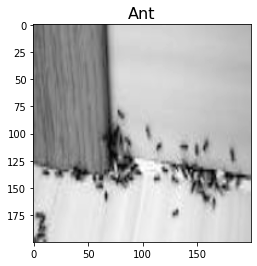

In [16]:
plt.imshow(X_test[17], cmap="gray")
plt.title(classes[torch.argmax(net(X_test[17].view(-1, 200 * 200))).item()].title(), fontsize=16)
plt.show()